In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download debeshjha1/kvasirseg

100% 144M/144M [00:08<00:00, 20.9MB/s]
100% 144M/144M [00:08<00:00, 18.0MB/s]


In [3]:
! unzip kvasirseg.zip

Archive:  kvasirseg.zip
  inflating: Kvasir-SEG/1911.07069.pdf  
  inflating: Kvasir-SEG/annotated_images/cju0qkwl35piu0993l0dewei2.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0qoxqj9q6s0835b43399p4.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0qx73cjw570799j4n5cjze.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0roawvklrq0799vmjorwfv.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0rx1idathl0835detmsp84.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0s2a9ekvms080138tjjpxr.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0s690hkp960855tjuaqvv0.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0sr5ghl0nd08789uzf1raf.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0sxqiclckk08551ycbwhno.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0t4oil7vzk099370nun5h9.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0tl3uz8blh0993wxvn7ly3.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0u2g7pmnux0801vkk47ivj.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0u82z3cuma0835w

In [5]:
import cv2
import numpy as np
import os

In [6]:
# Set the path to the Kvasir-SEG dataset directory
image_dir = "/content/Kvasir-SEG/images"
mask_dir = "/content/Kvasir-SEG/masks"

image_paths = []
mask_paths = []

# Get the file paths of the images and masks
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        image_paths.append(os.path.join(image_dir, filename))

for filename in os.listdir(mask_dir):
    if filename.endswith(".jpg"):
        mask_paths.append(os.path.join(mask_dir, filename))

images = []
masks = []

# Load the images and masks
for image_path, mask_path in zip(image_paths, mask_paths):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    images.append(image)
    masks.append(mask)

In [7]:
# Total number of images
print(f"Total images: {len(images)}\nTotal masks: {len(masks)}")

Total images: 1000
Total masks: 1000


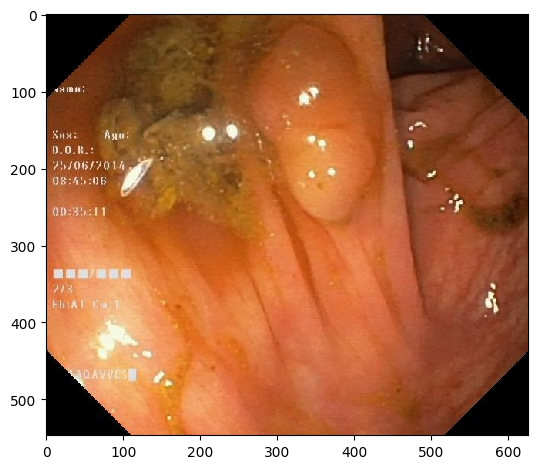

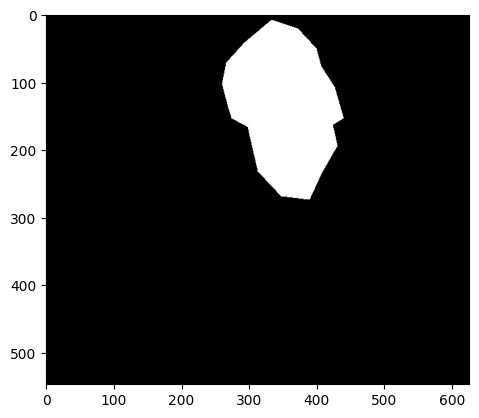

In [8]:
#Plotting random images and their mask
import random
import matplotlib.pyplot as plt
from skimage.io import imshow

image_x = random.randint(0, len(images))
imshow(images[image_x])
plt.show()
plt.imshow(np.squeeze(masks[image_x]))

In [9]:
#Resizing images and masks
from skimage.color import rgb2gray as rtg

resized_images = []
for image in images:
    resized_image = cv2.resize(image, (224, 224))
    resized_image = resized_image.astype('uint8')
    resized_images.append(resized_image)

resized_masks = []
for mask in masks:
    mask = rtg(mask)
    resized_mask = cv2.resize(mask, (224, 224))
    resized_mask = resized_mask.astype('bool')
    resized_masks.append(resized_mask)

# Convert resized_masks to numpy array
resized_masks = np.array(resized_masks)
resized_masks = np.expand_dims(resized_masks, axis=-1)
resized_images = np.array(resized_images)

In [10]:
print(f"X_train.shape: {resized_images.shape}\nY_train.shape: {resized_masks.shape}")

X_train.shape: (1000, 224, 224, 3)
Y_train.shape: (1000, 224, 224, 1)


In [11]:
#Normalize pixel values
normalized_images = np.array(resized_images) / 255.0

In [12]:
#Split dataset into train, validation and test sets
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(normalized_images, resized_masks, test_size=0.2, random_state=42)
test_images, val_images, test_masks, val_masks = train_test_split(val_images, val_masks, test_size=0.5, random_state=42)

In [13]:
#Data Augmentation
import imgaug.augmenters as iaa

augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-45, 45)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
   ])

augmented_train_images = augmenter(images=train_images)
augmented_train_masks = augmenter(images=train_masks)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_model(input_shape, num_classes):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [15]:
#Loss Function
import tensorflow.keras.backend as K
from keras.losses import binary_crossentropy

# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)

# def bce_dice_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# def bce_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred)

# def bce_loss(y_true, y_pred):
#     y_true_flat = tf.reshape(y_true, [-1])
#     y_pred_flat = tf.reshape(y_pred, [-1])
#     return binary_crossentropy(y_true_flat, y_pred_flat)


In [16]:
#Compile model
input_shape = (224, 224, 3)
num_classes = 1
model = unet_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [18]:
#Train the model
batch_size=8

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

# Preprocess the datasets (e.g., shuffle, batch, etc.)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

epochs = 30

#add Earlystop and Lr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model with the callbacks
model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
100/100 [==============================] - 32s 112ms/step - loss: 0.4467 - accuracy: 0.8279 - val_loss: 0.3924 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 10s 104ms/step - loss: 0.3896 - accuracy: 0.8342 - val_loss: 0.3919 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 10s 100ms/step - loss: 0.3804 - accuracy: 0.8342 - val_loss: 0.3579 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3601 - accuracy: 0.8346 - val_loss: 0.3490 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.3648 - accuracy: 0.8349 - val_loss: 0.3482 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 10s 100ms/step - loss: 0.3501 - accuracy: 0.8418 - val_loss: 0.3415 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 7/30
100/100 [==============================] 

In [19]:
model.evaluate(test_images, test_masks)

4/4 [==============================] - 4s 58ms/step - loss: 0.3217 - accuracy: 0.8568


[0.3216913342475891, 0.8568271398544312]

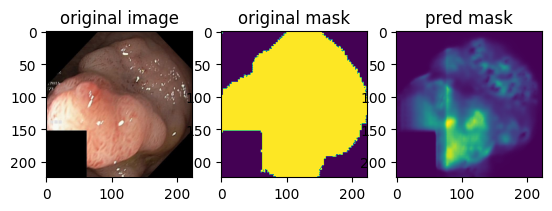

In [21]:
#Plotting some random images and corresponding descriptions

ind = random.randint(0, len(val_images))
img = val_images[ind]
predMask = model.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image")
ax1.imshow(val_images[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask")
ax2.imshow(np.squeeze(val_masks[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask")
ax3.imshow(np.squeeze(predMask))